Starting Beer Rating Analysis...
Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   beer/ABV           10 non-null     float64
 1   beer/style         10 non-null     object 
 2   review/appearance  10 non-null     float64
 3   review/aroma       10 non-null     float64
 4   review/overall     10 non-null     float64
 5   review/palate      10 non-null     float64
 6   review/taste       10 non-null     float64
 7   review/text        10 non-null     object 
 8   user/gender        7 non-null      object 
dtypes: float64(6), object(3)
memory usage: 848.0+ bytes
None

Summary Statistics:
       beer/ABV  review/appearance  review/aroma  review/overall  \
count  10.00000          10.000000     10.000000       10.000000   
mean    5.99000           3.800000      3.650000        3.700000   
std     1.36337           0.42

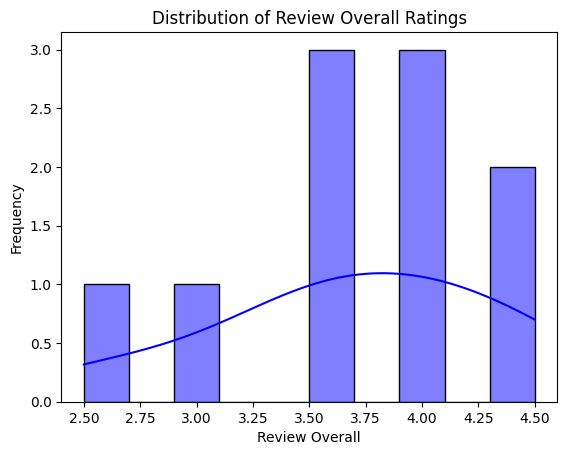

Missing Values Before Cleaning:
 beer/ABV             0
beer/style           0
review/appearance    0
review/aroma         0
review/overall       0
review/palate        0
review/taste         0
review/text          0
user/gender          3
dtype: int64
Top 10 Features by Importance:
                 Feature  Importance
4           review/taste    0.163612
2           review/aroma    0.144160
3          review/palate    0.143842
0               beer/ABV    0.115770
15                   ale    0.066144
10  style_Czech Pilsener    0.054054
43            refreshing    0.052900
42               pilsner    0.040025
1      review/appearance    0.034733
38                 light    0.032455
Results saved

Random Forest Results:
 - RMSE: 0.36
 - R2 Score: 0.47

Linear Regression Results:
 - RMSE: 0.39
 - R2 Score: 0.40


In [2]:
# Beer Rating Prediction

!pip install pandas numpy scikit-learn matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

def create_sample_dataset():
    return pd.DataFrame({
        "beer/ABV": [5.0, 6.5, 4.7, 7.2, 4.9, 8.1, 5.5, 6.0, 7.8, 4.2],
        "beer/style": [
            "Herbed / Spiced Beer", "American Barleywine", "American Pale Ale (APA)",
            "Czech Pilsener", "English Pale Ale", "American IPA", "American Lager",
            "Stout", "Pilsener", "Amber Ale"
        ],
        "review/appearance": [4.0, 3.5, 4.0, 3.0, 4.5, 3.5, 4.0, 4.0, 3.5, 4.0],
        "review/aroma": [4.0, 3.5, 4.0, 3.0, 3.0, 4.0, 4.5, 3.5, 4.0, 3.0],
        "review/overall": [4.0, 3.5, 3.5, 2.5, 3.0, 4.0, 4.5, 4.0, 4.5, 3.5],
        "review/palate": [4.0, 3.5, 3.5, 3.0, 3.5, 4.0, 4.0, 4.0, 4.5, 3.0],
        "review/taste": [4.0, 3.0, 3.5, 3.0, 2.5, 4.0, 4.5, 4.0, 4.5, 3.0],
        "review/text": [
            "A delightful beer with herbal notes.",
            "Rich and malty barleywine with a smooth finish.",
            "Crisp pale ale with citrusy notes.",
            "Light and refreshing pilsner.",
            "Balanced pale ale with fruity undertones.",
            "Hoppy IPA with a bold aroma.",
            "Clean lager with a subtle bitterness.",
            "Deep and rich stout with coffee notes.",
            "Bright pilsner with a crisp finish.",
            "Smooth amber ale with caramel hints."
        ],
        "user/gender": ["Male", "Female", None, "Male", None, "Female", "Male", "Male", None, "Female"]
    })

def perform_eda(data):
    print("Dataset Information:")
    print(data.info())
    print("\nSummary Statistics:")
    print(data.describe())

    sns.histplot(data['review/overall'], bins=10, kde=True, color='blue')
    plt.title('Distribution of Review Overall Ratings')
    plt.xlabel('Review Overall')
    plt.ylabel('Frequency')
    plt.show()

    print("Missing Values Before Cleaning:\n", data.isnull().sum())

def clean_data(data):
    data_cleaned = data.copy()

    numeric_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
    numeric_imputer = SimpleImputer(strategy='mean')
    data_cleaned.loc[:, numeric_cols] = numeric_imputer.fit_transform(data_cleaned[numeric_cols])

    data_cleaned['user/gender'] = data_cleaned['user/gender'].map({'Male': 1, 'Female': 2}).fillna(0).astype(int)
    return data_cleaned

def engineer_features(data):
    text_vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
    tfidf_features = text_vectorizer.fit_transform(data['review/text'])
    tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=text_vectorizer.get_feature_names_out())

    style_encoded = pd.get_dummies(data['beer/style'], prefix='style')

    features = pd.concat([
        data[['beer/ABV', 'review/appearance', 'review/aroma', 'review/palate', 'review/taste']].reset_index(drop=True),
        style_encoded.reset_index(drop=True),
        tfidf_df.reset_index(drop=True)
    ], axis=1)

    target = data['review/overall']
    return features, target

def train_and_evaluate(X_train, X_test, y_train, y_test):
    results = {}

    rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
    rf_model.fit(X_train, y_train)
    rf_y_pred = rf_model.predict(X_test)
    results['Random Forest'] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, rf_y_pred)),
        'R2': r2_score(y_test, rf_y_pred)
    }

    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_y_pred = lr_model.predict(X_test)
    results['Linear Regression'] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, lr_y_pred)),
        'R2': r2_score(y_test, lr_y_pred)
    }

    if hasattr(rf_model, 'feature_importances_'):
        feature_importances = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': rf_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        print("Top 10 Features by Importance:")
        print(feature_importances.head(10))
        feature_importances.to_csv("feature_importances.csv", index=False)

    pd.DataFrame({
        'Actual': y_test,
        'Predicted_RF': rf_y_pred,
        'Predicted_LR': lr_y_pred
    }).to_csv("predictions.csv", index=False)

    print("Results saved")
    return results

if __name__ == "__main__":
    print("Starting Beer Rating Analysis...")

    data = create_sample_dataset()
    perform_eda(data)

    data_cleaned = clean_data(data)
    features, target = engineer_features(data_cleaned)

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    results = train_and_evaluate(X_train, X_test, y_train, y_test)

    for model, metrics in results.items():
        print(f"\n{model} Results:")
        print(f" - RMSE: {metrics['RMSE']:.2f}")
        print(f" - R2 Score: {metrics['R2']:.2f}")
